<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/7_2_Funci%C3%B3n_de_similitud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Tabla de Contenido***
La mayoría de los puntos en este script se emplearon en el estudio de librerias quimioenfocadas.
- [0 - ***Importar librerias***](#0)
- [1 - ***Lectura de base de datos*** ](#1)
- [2 - ***Selección de función de similitud*** ](#2)
- [3 - ***Gráfico de identidad*** ](#3)
- [4 - ***Referencias*** ](#4)

<a name='0'></a>
# **Librerias: instalar e importar**

In [6]:
from IPython.utils import io
import tqdm.notebook
import os, os.path, sys, random, subprocess
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(20)
        #Librerias gráficas
        !pip install matplotlib
        import matplotlib.pyplot as plt
        import matplotlib.font_manager as font_manager
        %matplotlib inline
        import time

        !pip install seaborn
        import seaborn as sns
        pbar.update(40)
        #Librerias del sistema y herramientas primarias:
        import pandas as pd
        import warnings
        warnings.filterwarnings("ignore")
        %config Completer.use_jedi = False
        pbar.update(30)
        #Busqueda
        !pip install rdkit
        from rdkit import Chem, DataStructs
        from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, Descriptors3D, rdMolDescriptors, Scaffolds
        from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
        PandasTools.RenderImagesInAllDataFrames(images=True) #Para visualizar moléculas
        from rdkit.Chem.Draw import IPythonConsole
        import math
        from math import pi
        from pathlib import Path
        from tempfile import TemporaryDirectory
        !pip install numpy
        import numpy as np
        # Mount Google Drive and upload your PyMOL license
        from google.colab import drive
        drive.mount("/content/drive")
        pbar.update(10)

  0%|          | 0/100 [00:00<?, ?it/s]

<a name='1'></a>
# **1 - Lectura de base de datos**

In [2]:
url="https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets//08_Similitud_compounds_g9a.csv"
id=pd.read_csv(url,index_col=[0])
id.head()

,molecule_chembl_id,smiles,IC50,std_units,pIC50,molecular_species,heavy_atoms,full_mwt,hbd,hba,psa,rtb,alogp,num_ro5_violations,max_phase,document_chembl_id
0,CHEMBL4170225,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)nc2cc1...,"0,5",nM,"9,301029996",BASE,35.0,477.65,2.0,6.0,65.65,9.0,4.92,0.0,NaN,CHEMBL4130634
1,CHEMBL4162206,COc1cc2c(NC3CCN(C(C)C)CC3)cc(C3CCCCC3)nc2cc1OC...,"0,7",nM,"9,15490196",BASE,37.0,508.75,1.0,6.0,49.86,10.0,6.44,2.0,NaN,CHEMBL4130634
2,CHEMBL3109639,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C,"0,9",nM,"9,045757491",BASE,23.0,317.43,1.0,5.0,60.08,6.0,2.84,0.0,NaN,CHEMBL3108684
3,CHEMBL3109631,COc1cc2c(cc1OCC1CCN(C)C1)N=C(N)C21CCC1,1,nM,9,BASE,23.0,315.42,1.0,5.0,60.08,4.0,2.45,0.0,NaN,CHEMBL3108684
4,CHEMBL5187766,COc1cc2c(NCCN)ccnc2cc1OCCCN1CCCC1,"1,6",nM,"8,795880017",BASE,25.0,344.46,2.0,6.0,72.64,9.0,2.48,0.0,NaN,CHEMBL5113445


In [5]:
id.sort_values(by=["document_chembl_id"], ascending=False, inplace=True)
id = id.drop_duplicates(subset='molecule_chembl_id')
# Reset index
id.reset_index(drop=True, inplace=True)
print(id.shape)
id[0:3]

(436, 16)


,molecule_chembl_id,smiles,IC50,std_units,pIC50,molecular_species,heavy_atoms,full_mwt,hbd,hba,psa,rtb,alogp,num_ro5_violations,max_phase,document_chembl_id
0,CHEMBL5197586,Nc1ncnc2c1ncn2[C@H]1O[C@@H](CN(CCI)CCC[C@H](N)...,1800,nM,"5,744727495",ZWITTERION,30.0,535.34,5.0,11.0,185.87,10.0,-1.04,2.0,NaN,CHEMBL5136992
1,CHEMBL5172325,Nc1ncnc2c1ncn2[C@H]1O[C@@H](CSCC[C@H](N)C(=O)O...,1500,nM,"5,823908741",ZWITTERION,26.0,384.42,5.0,11.0,182.63,7.0,-1.44,1.0,NaN,CHEMBL5136992
2,CHEMBL5189737,CCC(=O)Nc1cc(NC2CCN(C(C)C)CC2)c2cc(OC)c(OCCCN3...,211,nM,"6,675717545",BASE,36.0,497.68,2.0,7.0,78.96,11.0,4.74,0.0,NaN,CHEMBL5126600


<a name='2'></a>
# **2 - Selección de función de similitud**

In [7]:
def similarity_calc(smi1, smi2, method='tanimoto'):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)

    if method == 'tanimoto':
      similarity = round(DataStructs.TanimotoSimilarity(fp1, fp2), 3)

    elif method == 'dice':
      similarity = round(DataStructs.DiceSimilarity(fp1, fp2), 3)

    elif method == 'cosine':
      similarity = round(DataStructs.CosineSimilarity(fp1, fp2), 3)

    elif method == 'euclidean':
      similarity = round(np.linalg.norm(arr1 - arr2), 3)

    else:
        raise ValueError("Method not recognized. Please use 'tanimoto', 'dice', 'cosine', or 'euclidean'.")

    return similarity

In [8]:
tic =time.time()
hmap=pd.DataFrame()
for i in id.index:
    for j in id.index:
        a=id.loc[i].at['smiles']
        b=id.loc[j].at['smiles']
        alignment= similarity_calc(a,b, 'tanimoto')
        hmap.loc[id.loc[i,'molecule_chembl_id'],id.loc[j,'molecule_chembl_id']]=alignment
toc =time.time()
print("Time: "+ str((toc-tic))+" s")
#Matriz de 414x414, con tiempo de ejecución aproximado de: 5 min

Time: 340.8634994029999 s


In [9]:
#hmap.to_excel('8_compound_aligment.xlsx')
hmap

,CHEMBL5197586,CHEMBL5172325,CHEMBL5189737,CHEMBL5191615,CHEMBL5170450,CHEMBL5189772,CHEMBL5188089,CHEMBL5183771,CHEMBL5207069,CHEMBL5172085,...,CHEMBL576260,CHEMBL578227,CHEMBL572373,CHEMBL585180,CHEMBL571951,CHEMBL571717,CHEMBL569864,CHEMBL570799,CHEMBL568964,CHEMBL570120
CHEMBL5197586,1.000,0.567,0.090,0.082,0.089,0.067,0.101,0.062,0.087,0.085,...,0.046,0.042,0.036,0.060,0.047,0.043,0.065,0.044,0.043,0.036
CHEMBL5172325,0.567,1.000,0.087,0.079,0.086,0.062,0.089,0.058,0.084,0.081,...,0.049,0.037,0.039,0.063,0.050,0.046,0.054,0.039,0.038,0.038
CHEMBL5189737,0.090,0.087,1.000,0.560,0.802,0.363,0.369,0.344,0.429,0.414,...,0.246,0.223,0.226,0.246,0.239,0.220,0.232,0.206,0.220,0.242
CHEMBL5191615,0.082,0.079,0.560,1.000,0.649,0.360,0.366,0.331,0.388,0.375,...,0.333,0.301,0.308,0.319,0.327,0.300,0.304,0.234,0.289,0.325
CHEMBL5170450,0.089,0.086,0.802,0.649,1.000,0.368,0.363,0.350,0.434,0.419,...,0.242,0.229,0.232,0.232,0.235,0.217,0.238,0.213,0.227,0.238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL571717,0.043,0.046,0.220,0.300,0.217,0.183,0.165,0.168,0.174,0.168,...,0.584,0.718,0.789,0.549,0.600,1.000,0.531,0.443,0.625,0.767
CHEMBL569864,0.065,0.054,0.232,0.304,0.238,0.221,0.185,0.205,0.202,0.195,...,0.406,0.730,0.615,0.400,0.429,0.531,1.000,0.547,0.724,0.568
CHEMBL570799,0.044,0.039,0.206,0.234,0.213,0.212,0.192,0.183,0.189,0.183,...,0.337,0.658,0.531,0.319,0.345,0.443,0.547,1.000,0.693,0.482
CHEMBL568964,0.043,0.038,0.220,0.289,0.227,0.206,0.187,0.178,0.184,0.178,...,0.470,0.887,0.740,0.443,0.481,0.625,0.724,0.693,1.000,0.675


<a name='1'></a>
# **3 - Gráfico de identidad**

In [10]:
palette= sns.blend_palette(['lightpink', 'purple'],74)
palette

[(1.0, 0.7137254901960784, 0.7568627450980392),
 (0.9941407151095732, 0.7053287197231835, 0.7538638985005767),
 (0.9863283352556709, 0.6941330257593233, 0.7498654363706266),
 (0.9804690503652441, 0.6857362552864283, 0.7468665897731641),
 (0.9726566705113417, 0.6745405613225682, 0.7428681276432141),
 (0.966797385620915, 0.6661437908496732, 0.7398692810457516),
 (0.9589850057670127, 0.6549480968858131, 0.7358708189158016),
 (0.953125720876586, 0.6465513264129181, 0.7328719723183391),
 (0.9453133410226836, 0.6353556324490581, 0.7288735101883891),
 (0.9394540561322569, 0.626958861976163, 0.7258746635909266),
 (0.9316416762783545, 0.615763168012303, 0.7218762014609765),
 (0.9257823913879277, 0.6073663975394079, 0.718877354863514),
 (0.9179700115340254, 0.5961707035755479, 0.714878892733564),
 (0.9121107266435986, 0.5877739331026528, 0.7118800461361015),
 (0.9042983467896963, 0.5765782391387928, 0.7078815840061514),
 (0.8984390618992695, 0.5681814686658977, 0.7048827374086889),
 (0.8906266820453672, 0.5569857747020377, 0.700884275278739),
 (0.8847673971549403, 0.5485890042291426, 0.6978854286812765),
 (0.8769550173010381, 0.5373933102652826, 0.6938869665513264),
 (0.8710957324106113, 0.5289965397923876, 0.6908881199538639),
 (0.863283352556709, 0.5178008458285275, 0.6868896578239139),
 (0.8574240676662822, 0.5094040753556325, 0.6838908112264513),
 (0.8496116878123798, 0.4982083813917724, 0.6798923490965013),
 (0.8437524029219531, 0.48981161091887737, 0.6768935024990388),
 (0.8359400230680507, 0.4786159169550173, 0.6728950403690888),
 (0.830080738177624, 0.47021914648212226, 0.6698961937716262),
 (0.8222683583237216, 0.4590234525182622, 0.6658977316416763),
 (0.8164090734332949, 0.45062668204536716, 0.6628988850442137),
 (0.8085966935793926, 0.43943098808150716, 0.6589004229142638),
 (0.8027374086889658, 0.4310342176086121, 0.6559015763168012),
 (0.7949250288350634, 0.41983852364475205, 0.6519031141868512),
 (0.7890657439446367, 0.411441753171857, 0.6489042675893887),
 (0.7812533640907343, 0.40024605920799694, 0.6449058054594387),
 (0.7753940792003076, 0.3918492887351019, 0.6419069588619761),
 (0.7675816993464052, 0.38065359477124183, 0.6379084967320261),
 (0.7617224144559784, 0.37225682429834683, 0.6349096501345636),
 (0.7539100346020762, 0.3610611303344867, 0.6309111880046137),
 (0.7480507497116493, 0.3526643598615917, 0.627912341407151),
 (0.740238369857747, 0.3414686658977316, 0.623913879277201),
 (0.7343790849673202, 0.3330718954248366, 0.6209150326797386),
 (0.7265667051134179, 0.3218762014609765, 0.6169165705497885),
 (0.7207074202229912, 0.3134794309880815, 0.613917723952326),
 (0.7128950403690888, 0.3022837370242215, 0.609919261822376),
 (0.707035755478662, 0.2938869665513264, 0.6069204152249135),
 (0.6992233756247597, 0.2826912725874664, 0.6029219530949634),
 (0.6933640907343329, 0.2742945021145713, 0.5999231064975009),
 (0.6855517108804305, 0.2630988081507113, 0.595924644367551),
 (0.6796924259900039, 0.2547020376778163, 0.5929257977700885),
 (0.6718800461361014, 0.24350634371395619, 0.5889273356401384),
 (0.6660207612456748, 0.2351095732410612, 0.5859284890426759),
 (0.6582083813917724, 0.22391387927720108, 0.5819300269127259),
 (0.6523490965013456, 0.21551710880430608, 0.5789311803152634),
 (0.6445367166474433, 0.20432141484044597, 0.5749327181853133),
 (0.6386774317570165, 0.19592464436755097, 0.5719338715878508),
 (0.6308650519031141, 0.18472895040369086, 0.5679354094579008),
 (0.6250057670126874, 0.17633217993079586, 0.5649365628604383),
 (0.6171933871587851, 0.16513648596693586, 0.5609381007304883),
 (0.6113341022683583, 0.15673971549404075, 0.5579392541330257),
 (0.603521722414456, 0.14554402153018076, 0.5539407920030758),
 (0.5976624375240291, 0.13714725105728565, 0.5509419454056133),
 (0.5898500576701269, 0.12595155709342565, 0.5469434832756632),
 (0.5839907727797, 0.11755478662053054, 0.5439446366782007),
 (0.5761783929257978, 0.10635909265667054, 0.5399461745482507),
 (0.570319108035371, 0.09796232218377543, 0.5

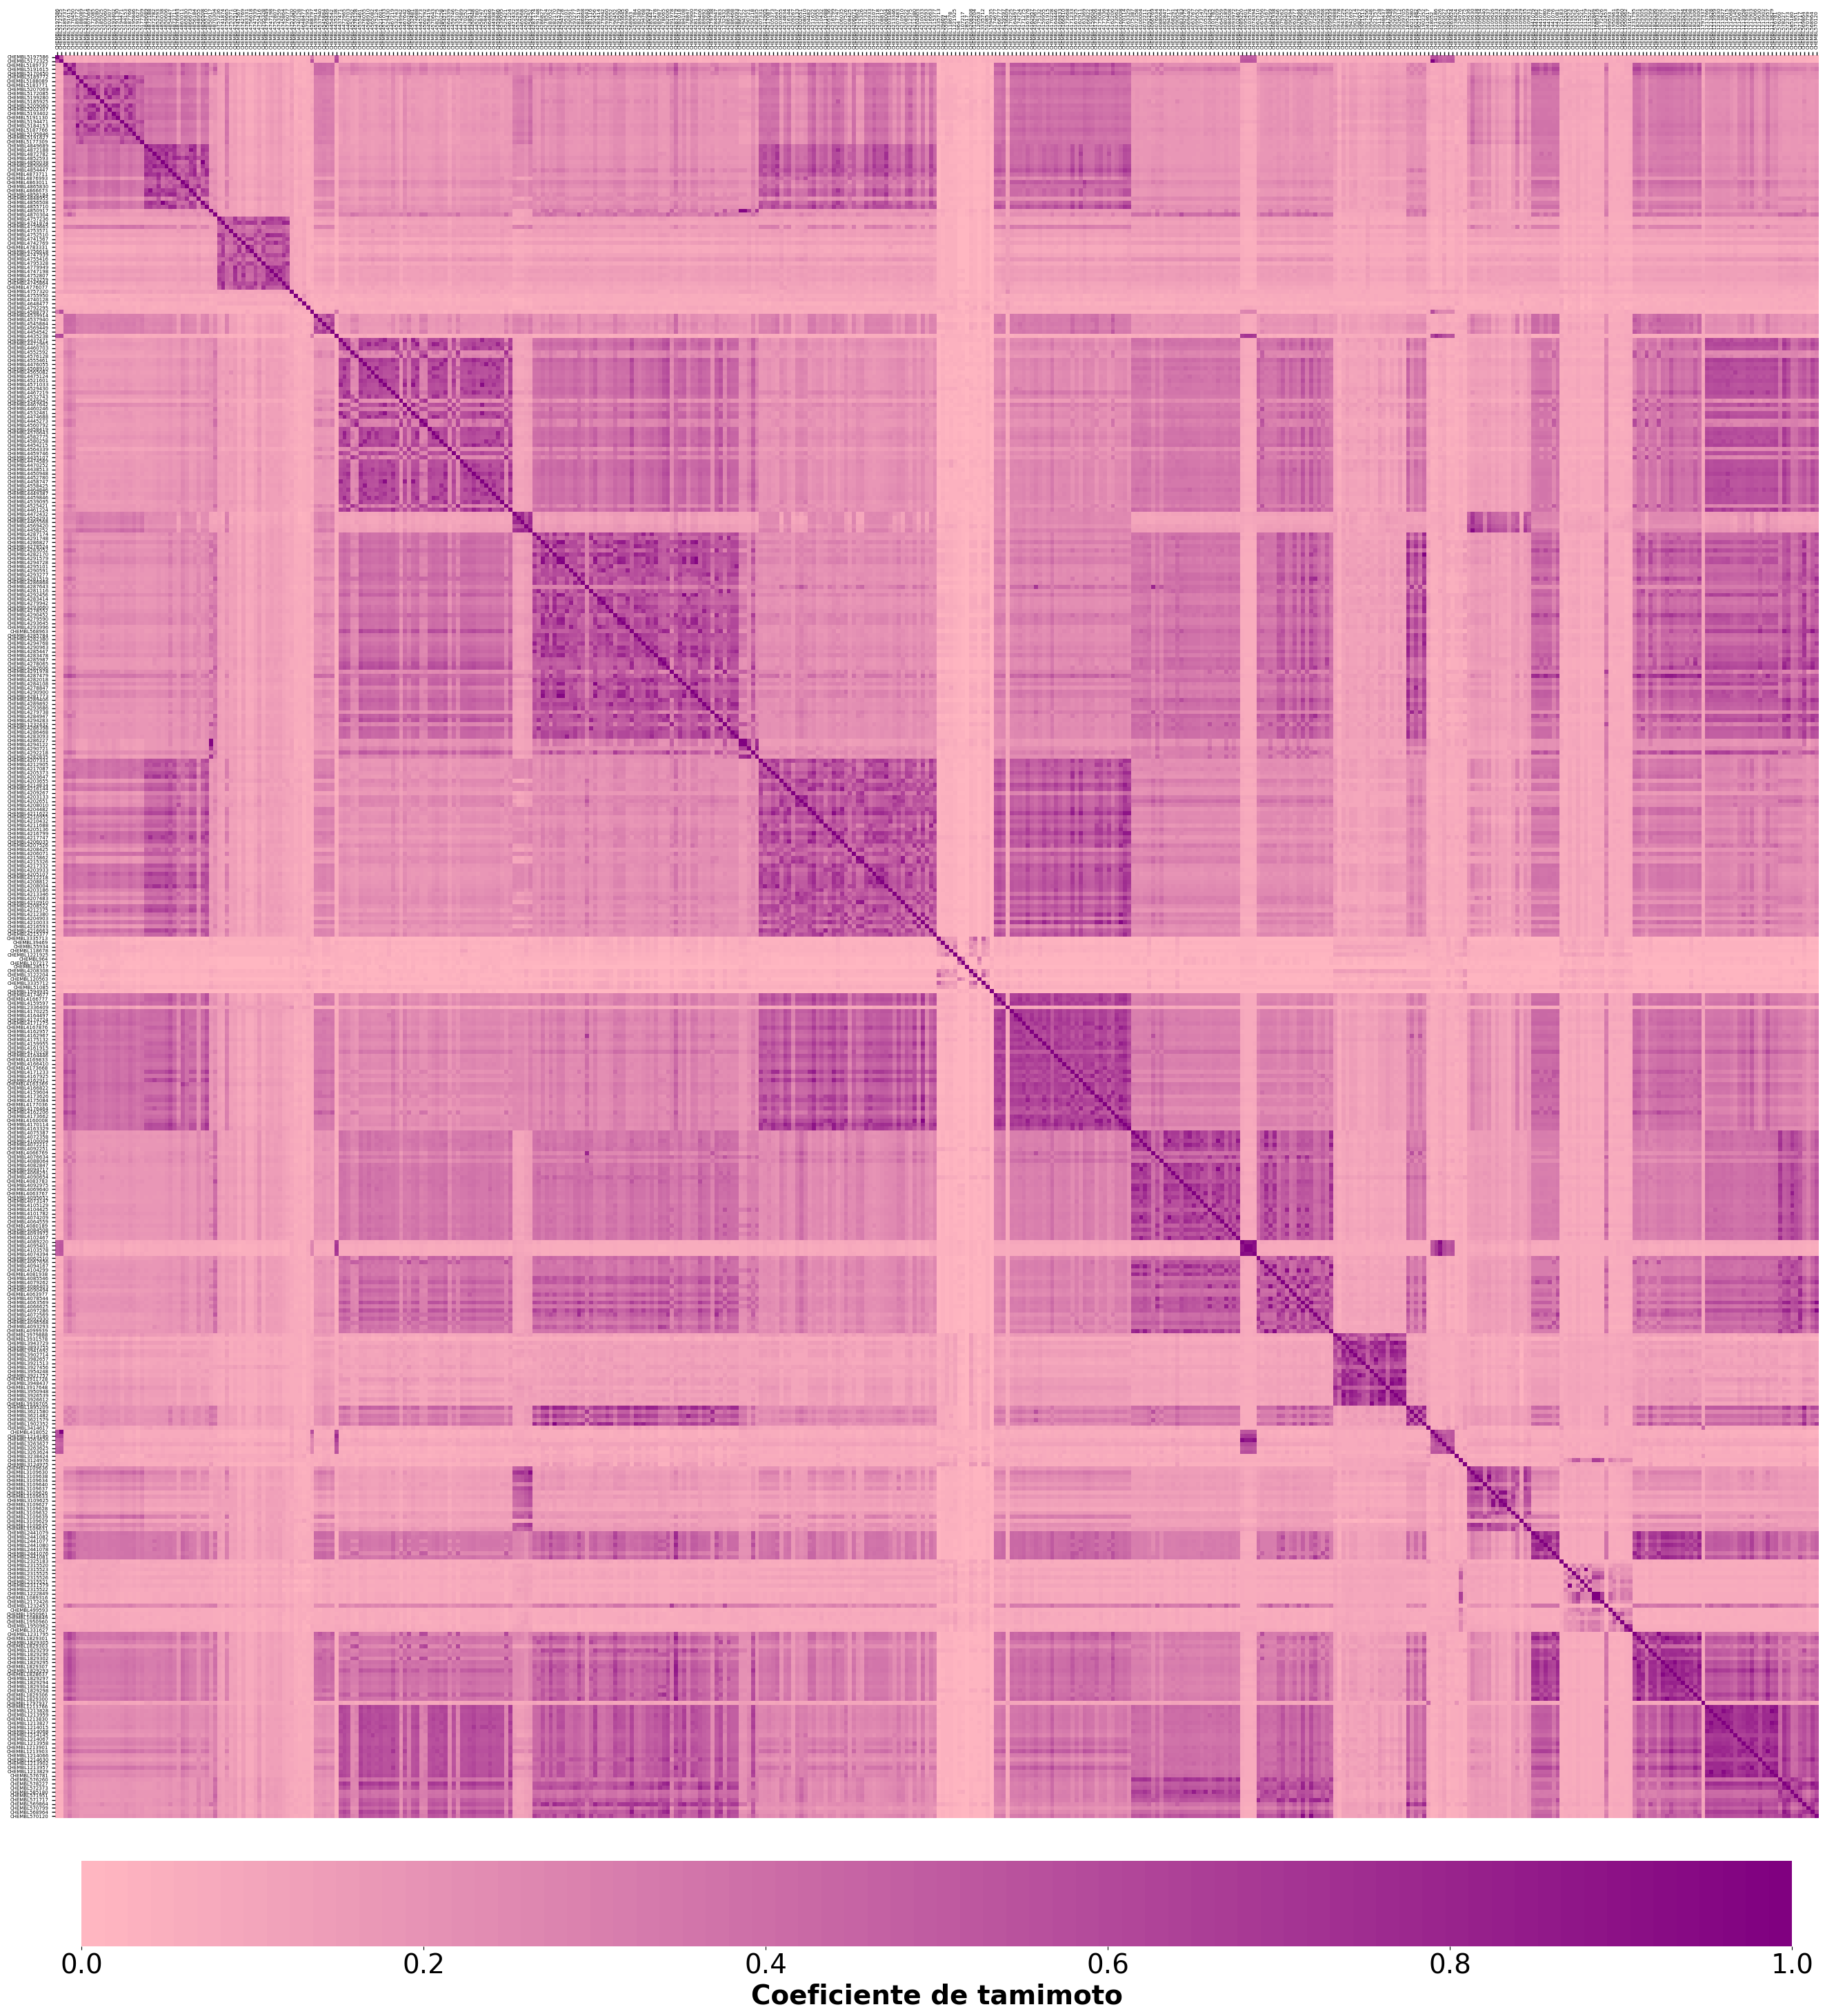

In [11]:
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(hmap,square = True, xticklabels=hmap.columns, yticklabels=hmap.index, cmap=palette, vmin=0, vmax=1,
            cbar_kws={'shrink':0.8,
                      'orientation':'horizontal','spacing':'uniform',
                      'pad':0.02})
ax.figure.axes[1].tick_params(axis="x", labelsize=28) #Tamaño de ticks en cbar
ax.figure.axes[1].set_xlabel('Coeficiente de tamimoto', size=28, weight='bold') #Etiqueta de cbar
ax.tick_params(labelsize=28)
plt.xticks (np.arange(len(hmap.index))+0.5, hmap.index,rotation=90)
plt.yticks (np.arange(len(hmap.columns))+0.5, hmap.columns, rotation=0)
ax.xaxis.tick_top()
plt.tick_params ('both',width=1,labelsize=5)
plt.savefig('Coeficiente_tanimoto.png',dpi=300,format='png',transparent=False)
plt.show()

<a name='4'></a>
# **4 - Referencias:**

1.   https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html
2.   https://gist.github.com/leelasd/746f3c447805fc6ea5aad1071bd77aef

*   https://github.com/rdkit/UGM_2014/blob/master/Notebooks/Scaffold%20analysis%20of%20ChEMBL%20data%20with%20pandas%20and%20RDKit/Scaffold%20analysis%20of%20ChEMBL%20data%20with%20pandas%20and%20RDKit%20-%20RDKit%20UGM2014.ipynb
*   https://github.com/rdkit/UGM_2013/blob/master/Tutorials/pandastools/Pandas_RDKit_UGM.ipynb
*https://github.com/rdkit/UGM_2013/blob/master/Tutorials/pandastools/Pandas_RDKit_UGM.ipynb

